In [1]:
from astropy.io import fits
import numpy as np
from glob import glob 
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from reproject import reproject_interp
from matplotlib import pyplot as plt
from glob import glob 
from tqdm import tqdm
import warnings 
from astropy.table import Table, join
import pickle
from matplotlib.ticker import (AutoMinorLocator)
from astropy.modeling import models, fitting
import sys
import warnings 
sys.path.append('./../modules/')
warnings.filterwarnings('ignore')

from tools_contsub_misc import *
from tools_contsub_anchoring import * 
from tools_contsub_plots import *

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in" 

plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [2]:
def save_pickle(a, filename):
    """
    Save an object to a pickle file.
    """
    with open(filename, 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('[INFO] [save_pickle] Saved to %s' %filename)

def load_pickle(filename):
    """
    Load an object from a pickle file.
    """
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
    print('[INFO] [load_pickle] Load %s' %filename)
    return b

def get_hdu(rootdir, filename, hdu_id=0):
    filename_full = glob(rootdir+filename)[0]
    print(filename_full)
    if hdu_id == 'all':
        hdu = fits.open(filename_full)
    else:
        hdu = fits.open(filename_full)[hdu_id]
    return(hdu)

def get_flux_nebs(hdu1, hdu2, hdu_neb1, hdu_neb2, filter='', make_plots=True):

    data_neb = hdu_neb1.data.copy()
    ids1 = np.unique(data_neb)
    ids1.sort()
    ids1 = list(ids1)
    ids1.remove(-1)

    data_neb = hdu_neb2.data.copy()
    ids2 = np.unique(data_neb)
    ids2.sort()
    ids2 = list(ids2)
    ids2.remove(-1)

    ids = []
    for id in tqdm(np.unique(np.hstack([ids1, ids2]))):
        if (id in ids1) &  (id in ids2): 
            ids += [id]

    flux_1 = np.ones(len(ids))
    flux_2 = np.ones(len(ids))
    nan_1 = np.ones(len(ids))
    nan_2 = np.ones(len(ids))
    
    for i in tqdm(range(len(ids))): 

        id = ids[i]

        mask1 = hdu_neb1.data == id
        mask2 = hdu_neb2.data == id

        flux_1[i] = np.nansum(hdu1.data[mask1])
        flux_2[i] = np.nansum(hdu2.data[mask2])

        nan_1[i] = np.sum(np.isnan(hdu1.data[mask1]))
        nan_2[i] = np.sum(np.isnan(hdu2.data[mask2]))
                          
    return(flux_1, flux_2, ids, nan_1, nan_2)

def get_museprops(galaxy, muscat_file):
    """
    Get properties from MUSE catalouge
    """

    print(f'[INFO] [get_MuseProps] Getting MUSE catalouge properties for {galaxy}...')
    muscat_table = Table.read(muscat_file)
    muscat_table = muscat_table[muscat_table['gal_name'] == galaxy.swapcase()]
    return(muscat_table)


In [3]:
galaxies = [
            'ic5332',
            'ngc628e',
            'ngc628c',  
            'ngc1087',          
            'ngc1300',
            'ngc1365n',
            'ngc1385',
            'ngc1433',
            'ngc1512',
            'ngc1566',
            'ngc1672',
            'ngc2835s',
            'ngc3351',
            'ngc3627',
            'ngc4254',
            'ngc4303',
            'ngc4321',
            'ngc5068',
            'ngc7496',
            ]

galaxies_muse = [
            'ic5332',
            'ngc0628',
            'ngc0628',  
            'ngc1087',          
            'ngc1300',
            'ngc1365',
            'ngc1385',
            'ngc1433',
            'ngc1512',
            'ngc1566',
            'ngc1672',
            'ngc2835',
            'ngc3351',
            'ngc3627',
            'ngc4254',
            'ngc4303',
            'ngc4321',
            'ngc5068',
            'ngc7496',
            ]

# galaxies = ['ngc628c']
# galaxies_muse = ['ngc0628']

root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
muscat_table_file = '%s/data_misc/Nebulae_catalogue_v4/Nebulae_catalogue_v4.fits' %root_dir

In [4]:
muscat_table_joined_all = {}
run = False 

if run: 
    for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 

        # Load files for galaxy
        print (galaxy, galaxy_muse)
        rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/%s/' %galaxy
        hdu_muse_neb    = get_hdu(rootdir, 'muse/%s_nebmask.fits' %galaxy_muse.upper())
        hdu_muse        = get_hdu(rootdir, 'muse/%s*_MAPS.fits' %galaxy_muse.upper(), 'all')
        hdu_muse_ha     = hdu_muse['HA6562_FLUX']
        hdu_hst_ha_crop = get_hdu(rootdir, 'hst_contsub/%s_hst_ha.fits' %galaxy)

        # Load MUSE properties
        muscat_table = get_museprops(galaxy_muse, muscat_table_file)

        # Reproject MUSE mask to HST grid
        data_output = reproject_interp(hdu_muse_neb, hdu_hst_ha_crop.header, order='nearest-neighbor')[0]
        hdu_muse_neb_re = fits.PrimaryHDU(data_output, hdu_hst_ha_crop.header)

        # Extract fluxes from MUSE and HST 
        flux_1, flux_2, ids, nan_1, nan_2 = get_flux_nebs(hdu_muse_ha, hdu_hst_ha_crop, hdu_muse_neb, hdu_muse_neb_re)

        # Make MUSE catalouge table
        unit = muscat_table['HA6562_FLUX'].unit
        data = [ids, flux_1*unit, flux_2*unit, (flux_2*unit)/(flux_1*unit), nan_1, nan_2]
        names = ['region_ID', 'flux_muse', 'flux_hst', 'flux_hst/muse', 'nan_muse', 'nan_hst']
        table_neb = Table(data=data, names=names)
        muscat_table_joined = join(table_neb, muscat_table, keys='region_ID')

        muscat_table_joined_all[galaxy] = muscat_table_joined

    save_pickle(muscat_table_joined_all, './muscat_table_joined_all.pkl')
else:
    muscat_table_joined_all = load_pickle('./muscat_table_joined_all.pkl')

[INFO] [load_pickle] Load ./muscat_table_joined_all.pkl


In [5]:
bbox = dict(facecolor='whitesmoke',  alpha=0.95, boxstyle='round')

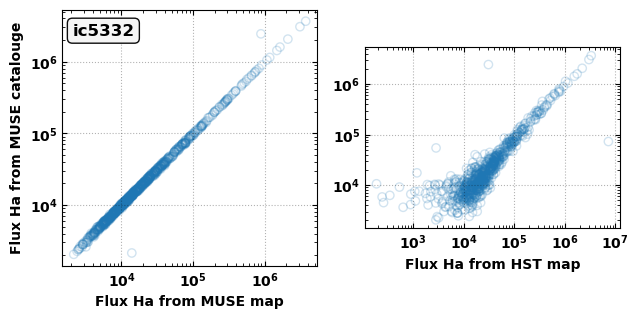

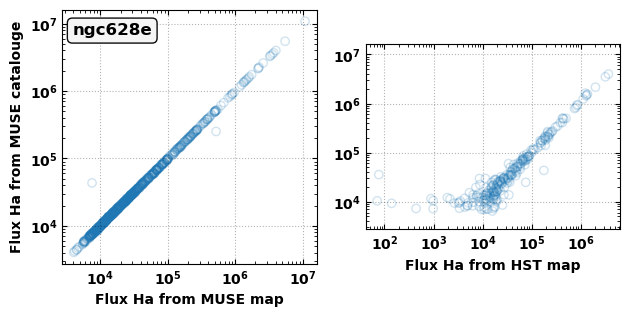

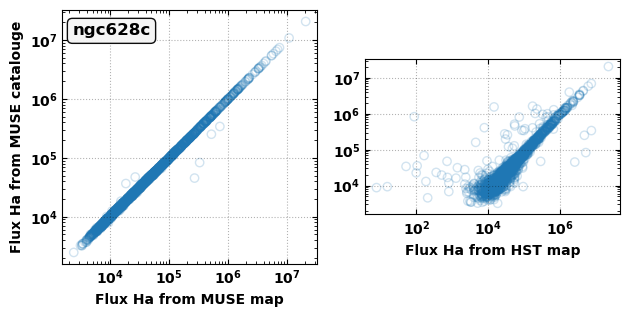

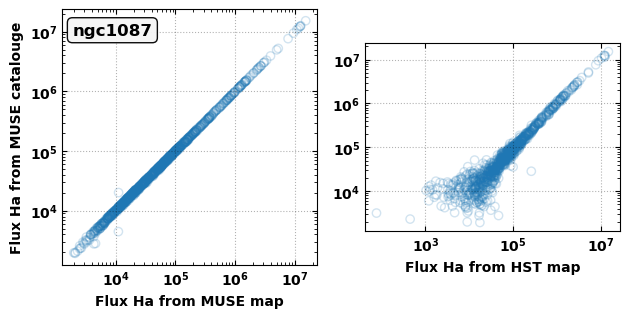

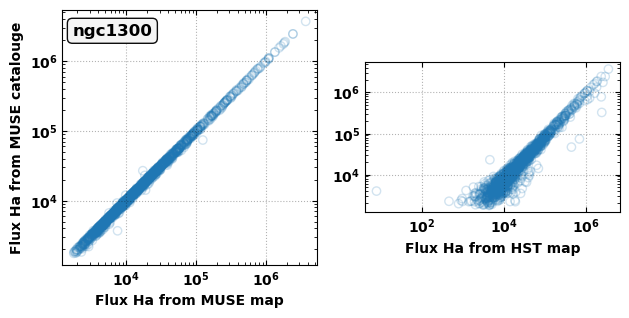

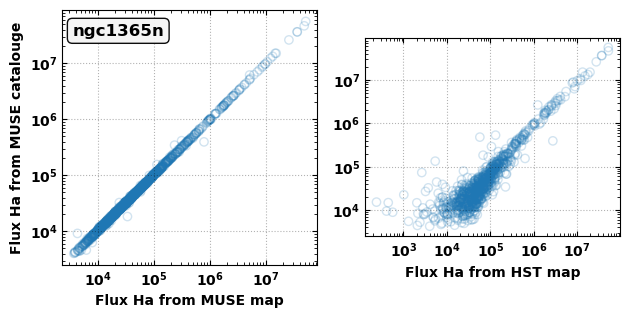

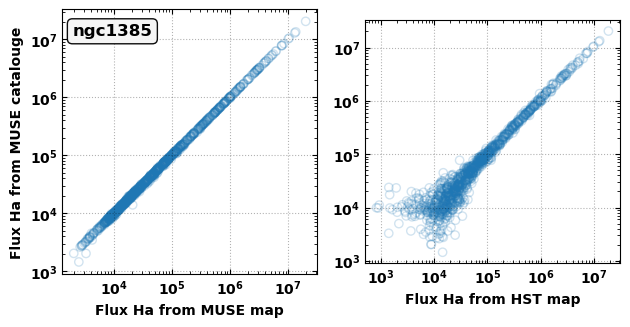

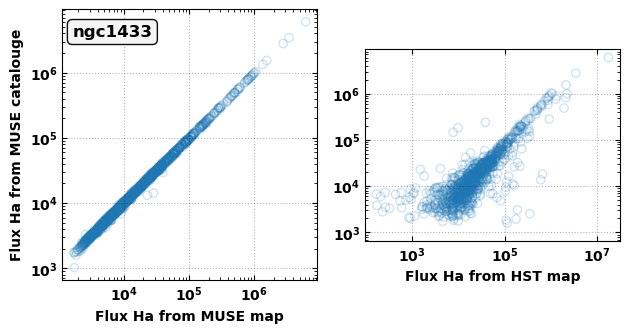

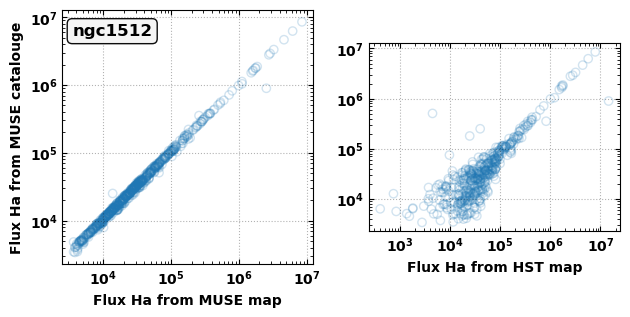

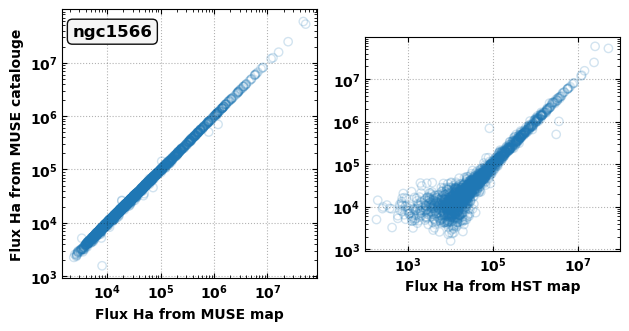

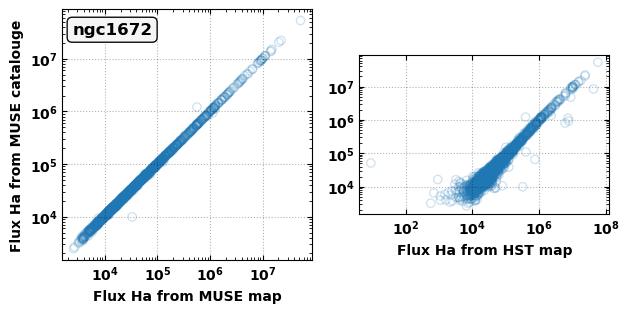

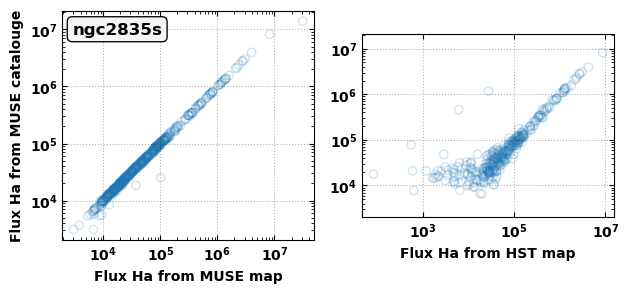

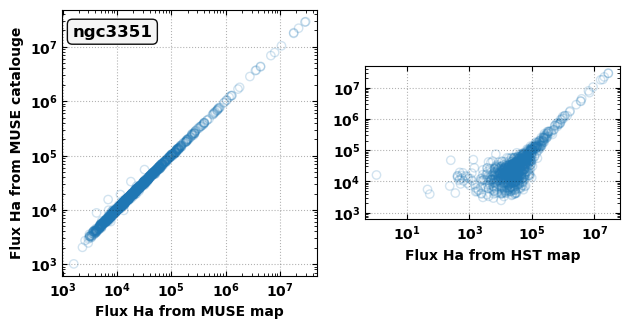

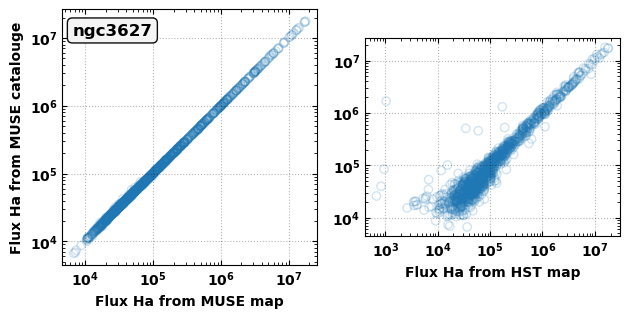

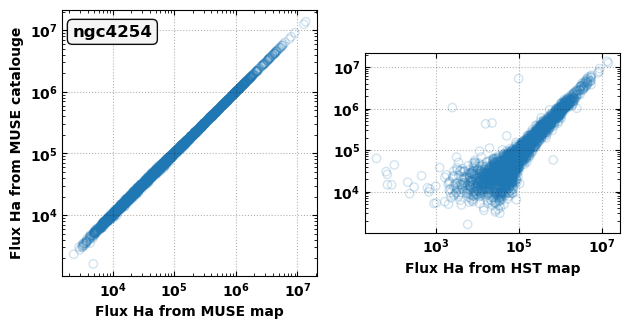

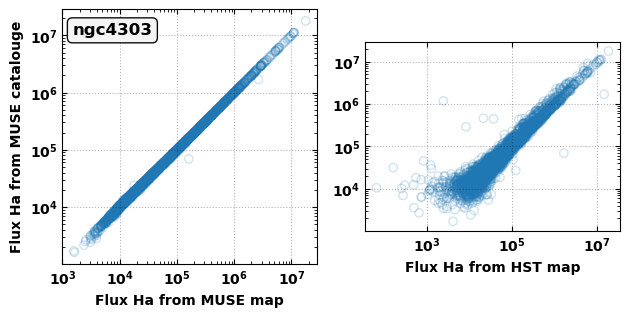

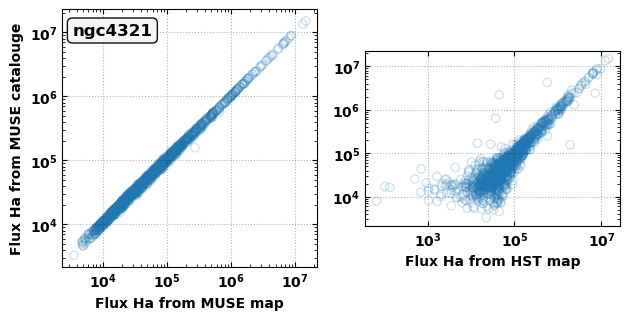

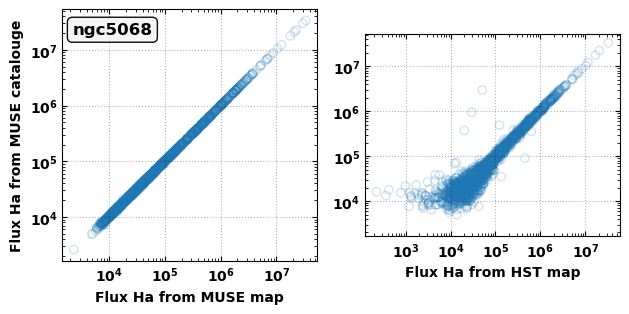

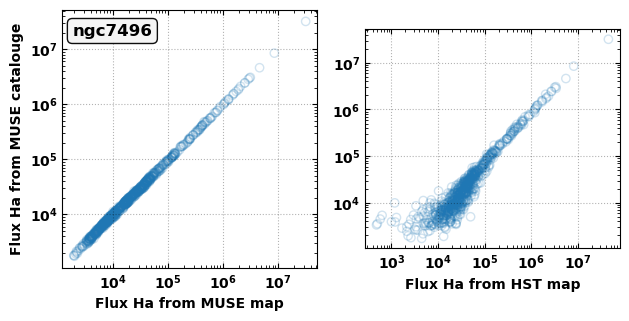

In [6]:
for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 

    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, sharey=ax1)

    ax1.set_aspect('equal')
    ax2.set_aspect('equal')

    ax1.scatter(muscat_table_joined_all[galaxy]['flux_muse'], muscat_table_joined_all[galaxy]['HA6562_FLUX'], fc='none', ec='C0', alpha=0.2)
    ax2.scatter(muscat_table_joined_all[galaxy]['flux_hst'], muscat_table_joined_all[galaxy]['HA6562_FLUX'], fc='none', ec='C0', alpha=0.2)

    ax1.set_xlabel('Flux Ha from MUSE map')
    ax1.set_ylabel('Flux Ha from MUSE catalouge')
    ax2.set_xlabel('Flux Ha from HST map')

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')

    ax1.text(0.04, 0.9, '%s' %galaxy, transform=ax1.transAxes, bbox=bbox, fontsize=12)

    ax1.grid(True, alpha=0.3, ls=':', color='black')
    ax2.grid(True, alpha=0.3, ls=':', color='black')
    fig.tight_layout()

    fig.savefig('./figs/%s_fluxcomp.pdf' %galaxy, bbox_inches='tight', dpi=300)  

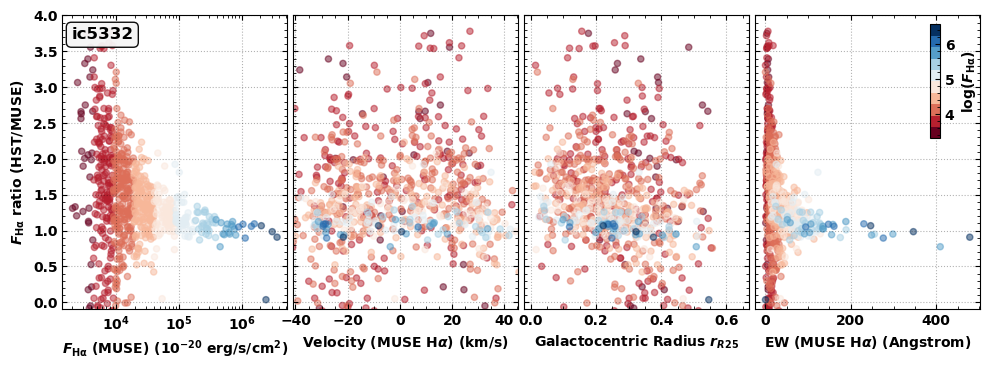

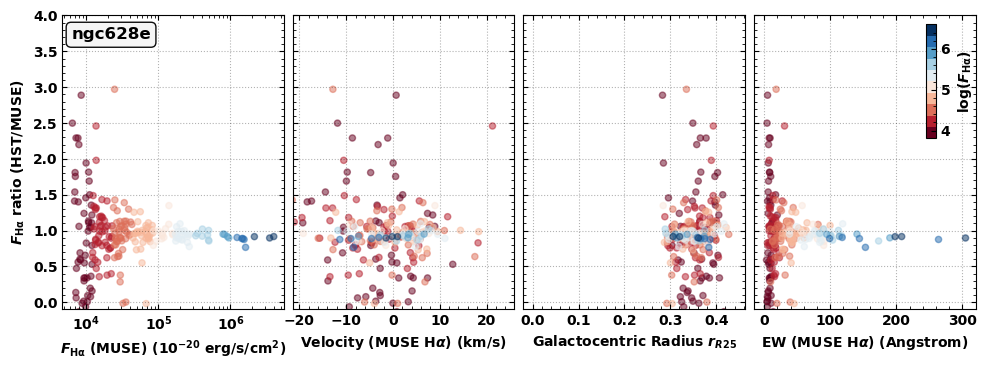

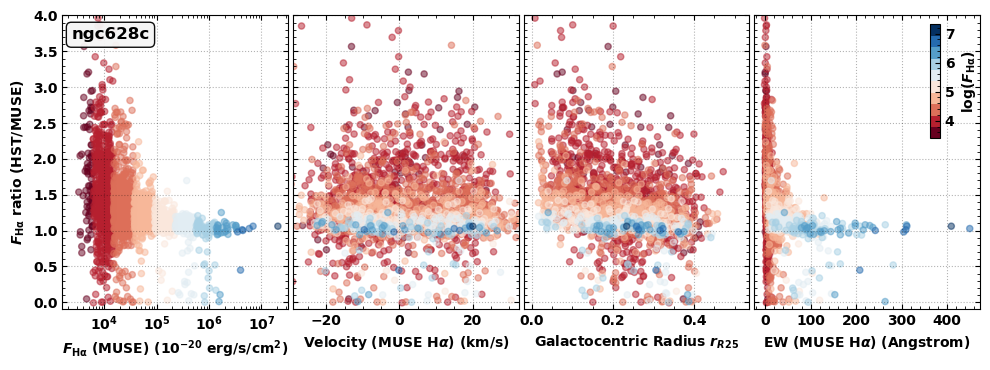

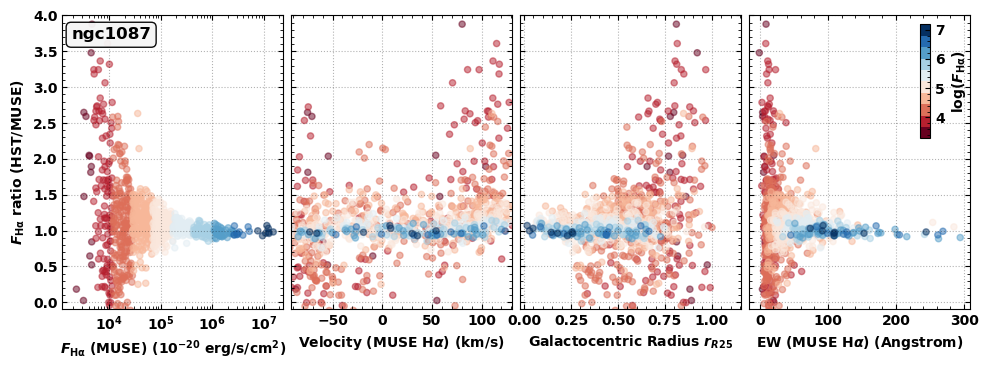

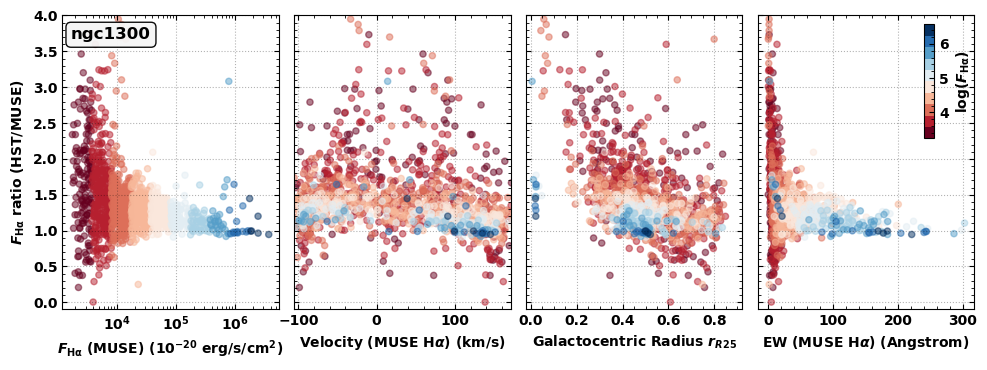

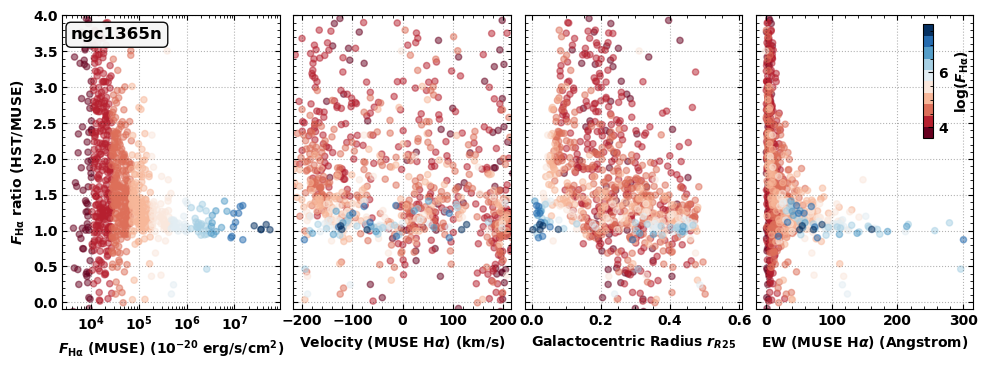

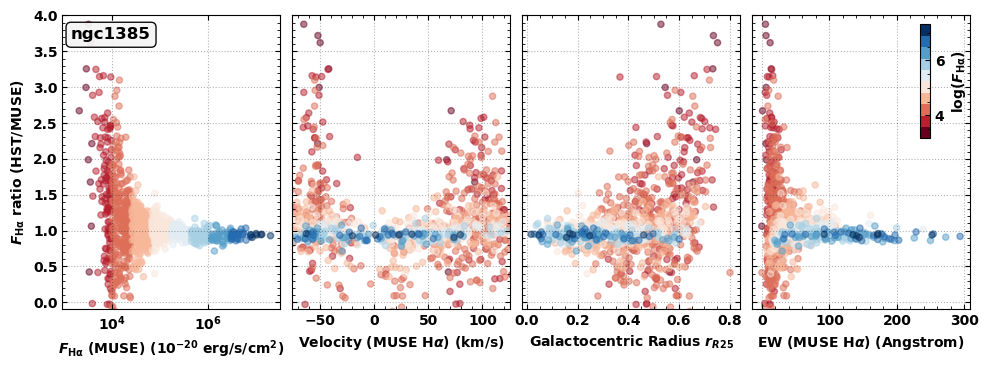

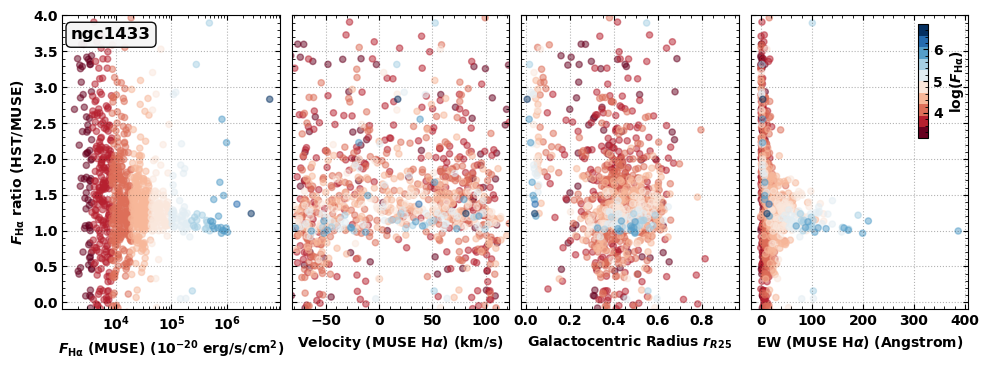

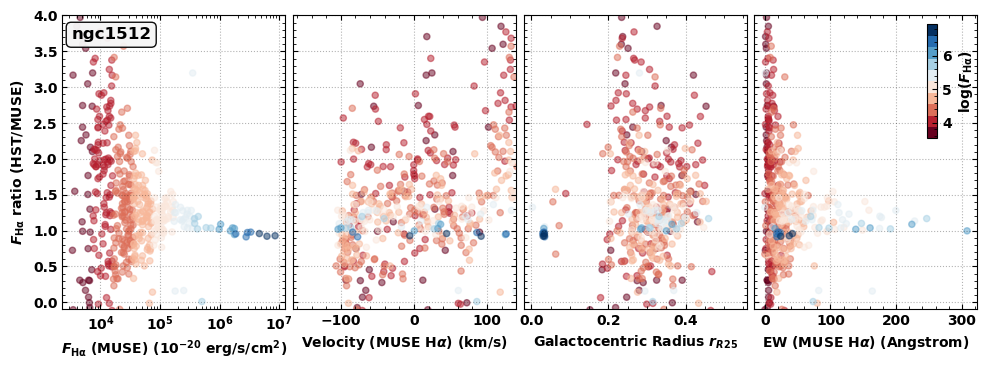

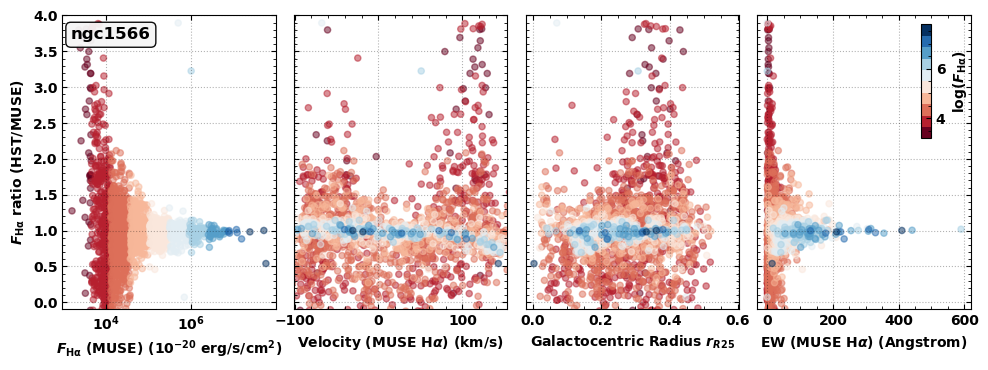

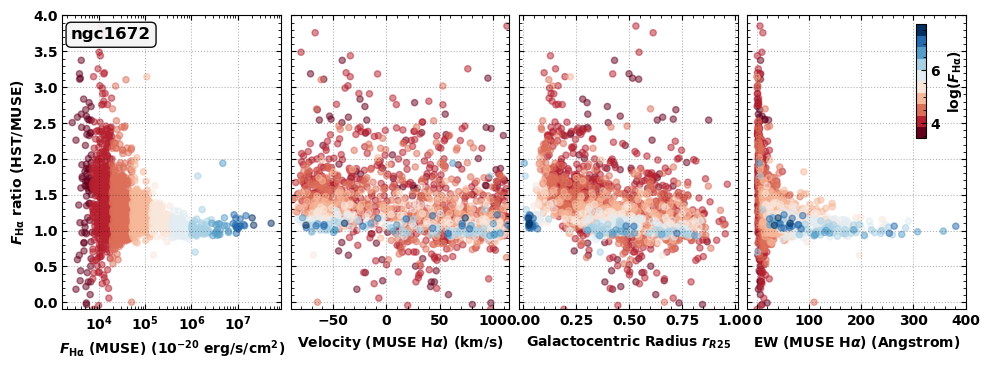

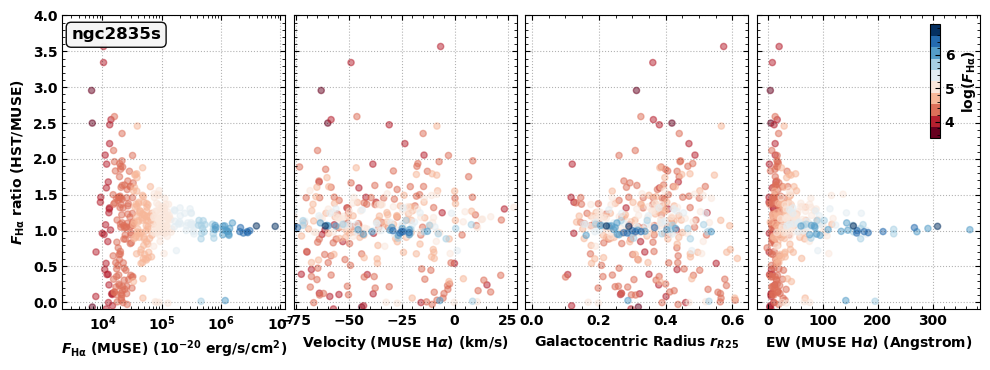

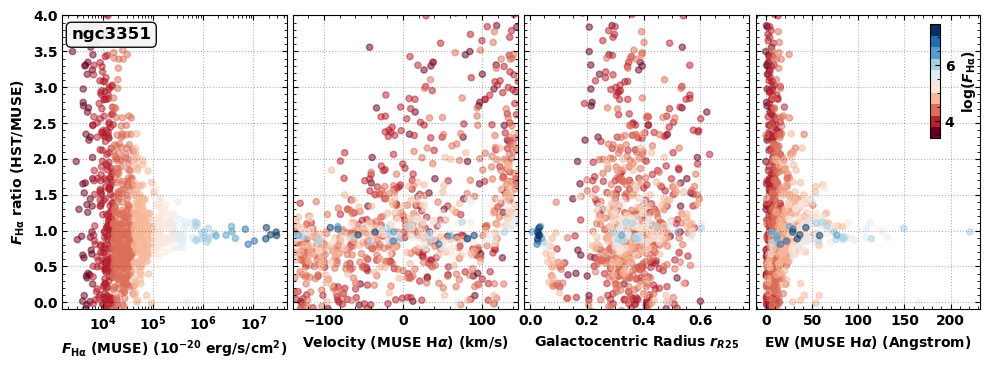

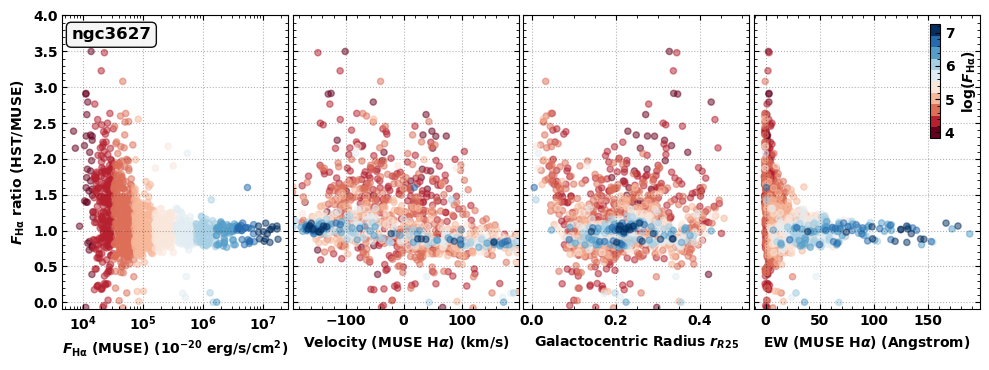

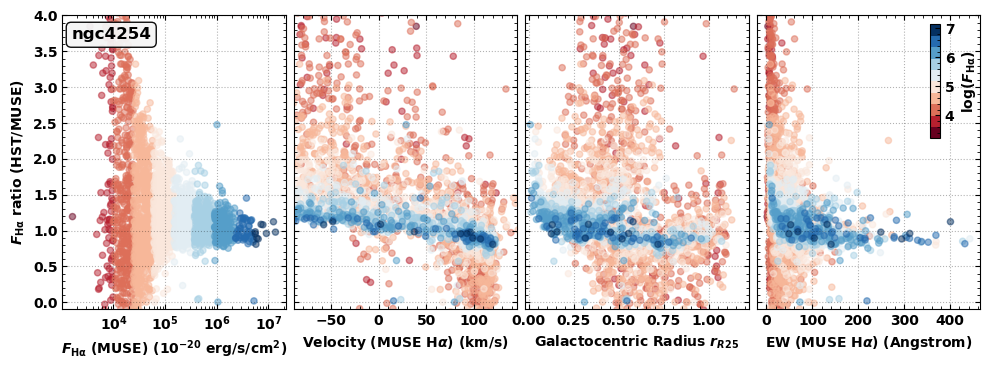

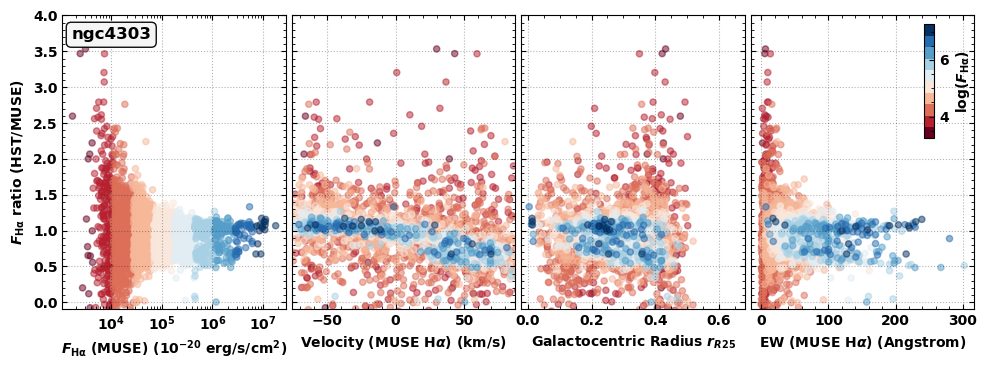

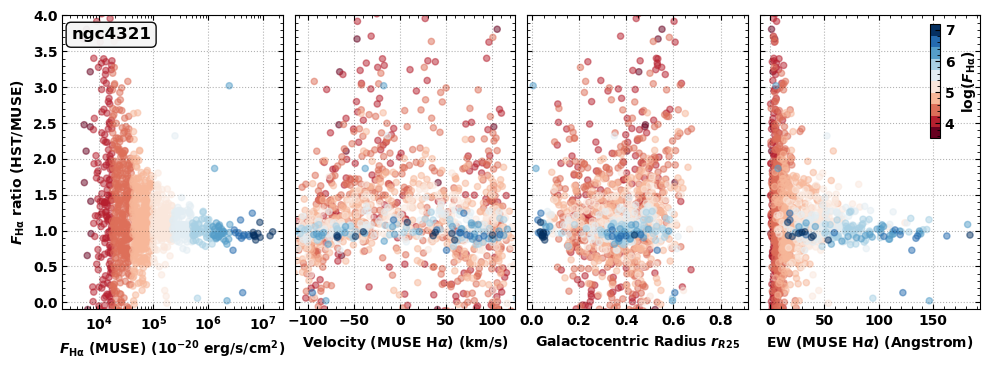

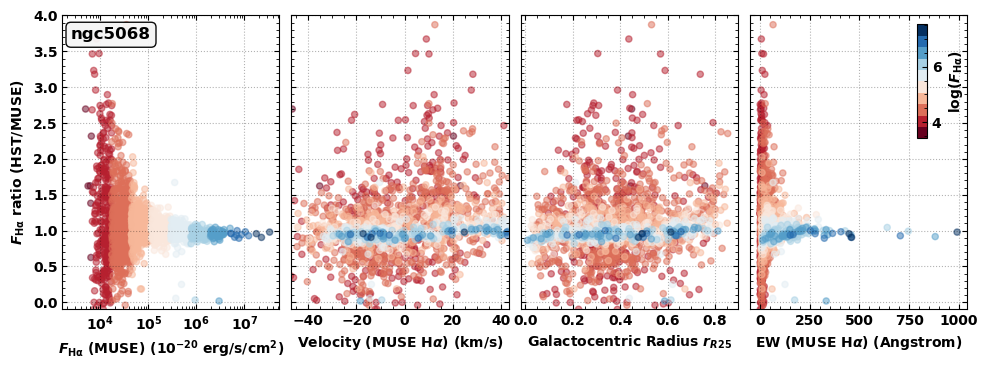

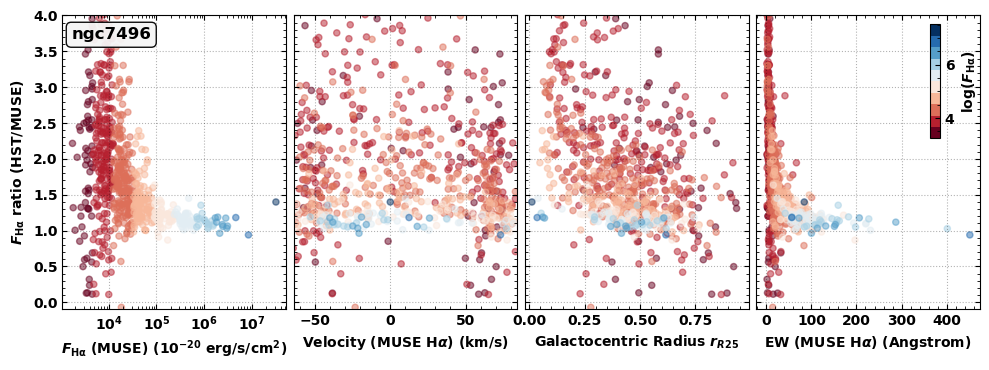

In [7]:
for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 
# for galaxy, galaxy_muse in zip([galaxies[2]], [galaxies_muse[2]]): 

    fig = plt.figure(figsize=(10, 3.8))

    from matplotlib import gridspec
    gs = gridspec.GridSpec(1, 4, width_ratios=[1,1,1,1]) 

    ax1 = fig.add_subplot(gs[2])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[0]) 
    ax4 = fig.add_subplot(gs[3])

    table = muscat_table_joined_all[galaxy].copy()
    table.sort('HA6562_FLUX')

    ratio = table['flux_hst/muse']
    mask = ratio!=0
    mask_lum = muscat_table_joined_all[galaxy]['HA6562_FLUX'][mask] > 1e6

    ratio = table['flux_hst/muse'][mask]
    r_R25 = table['r_R25'][mask]
    HA6562_VEL = table['HA6562_VEL'][mask]
    HA6562_FLUX = table['HA6562_FLUX'][mask]
    EW_HA6562_raw = table['EW_HA6562'][mask]

    cdata = HA6562_FLUX
    cdata = np.log10(cdata)
    cmap = plt.get_cmap('RdBu', 10)
    norm = mpl.colors.Normalize(vmin=3, vmax=7)

    im = ax1.scatter(r_R25, ratio, cmap=cmap, c=cdata, alpha=0.5, s=20)
    im = ax1.scatter([-10,-10], [0,0], cmap=cmap, c=np.nanpercentile(cdata,[0,100]))

    ax2.scatter(HA6562_VEL, ratio, cmap=cmap, c=cdata, alpha=0.5, s=20)
    ax3.scatter(HA6562_FLUX, ratio, cmap=cmap, c=cdata, alpha=0.5, s=20)
    ax4.scatter(EW_HA6562_raw, ratio, cmap=cmap, c=cdata, alpha=0.5,  s=20)

    # bin_values = get_bins(HA6562_VEL[mask_lum], ratio[mask_lum], 10, equal_spaced=False)
    # ax2.plot(bin_values[0], bin_values[1], color='black', lw=2)

    ax3.set_ylabel(r'$F_\mathrm{H\alpha}$ ratio (HST/MUSE)')
    ax1.set_xlabel(r'Galactocentric Radius $r_{R25}$')
    ax2.set_xlabel(r'Velocity (MUSE H$\alpha$) (km/s)')
    ax3.set_xlabel(r'$F_\mathrm{H\alpha}$ (MUSE) (10$^{-20}$ erg/s/cm$^2$)')
    ax4.set_xlabel(r'EW (MUSE H$\alpha$) (Angstrom)')

    for ax in [ax1,ax2,ax3,ax4]:

        ax.set_ylim(-0.1, 4)
        ax.grid(True, alpha=0.3, ls=':', color='black')

    ax1.set_xlim([-.02, muscat_table_joined_all[galaxy]['r_R25'][mask].max()*1.05])
    ax2.set_xlim(np.nanpercentile(muscat_table_joined_all[galaxy]['HA6562_VEL'][mask], [0.5,99.5]))

    ax3.set_xscale('log')

    ax2.set_yticklabels([])
    ax1.set_yticklabels([])
    ax4.set_yticklabels([])

    for ax in [ax1,ax2,ax4]:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax3.yaxis.set_minor_locator(AutoMinorLocator())

    ax3.text(0.04, 0.96, '%s' %galaxy, transform=ax3.transAxes, bbox=bbox, fontsize=12, va='top')

    plt.tight_layout(h_pad=0, w_pad=-0.1)

    cbaxes = fig.add_axes([ax4.get_position().x1-0.05, ax4.get_position().y0+0.45, 0.01, 0.3]) 
    plt.colorbar(im, cax=cbaxes, label=r'log($F_\mathrm{H\alpha}$)')

    fig.savefig('./figs/%s_ratiocomp.pdf' %galaxy, bbox_inches='tight', dpi=300)  

ic5332: 0.44 0.11
ngc628e: 0.14 0.07
ngc628c: 0.24 0.09
ngc1087: 0.17 0.09
ngc1300: 0.24 0.14
ngc1365n: 0.45 0.15
ngc1385: 0.13 0.06
ngc1433: 0.45 0.12
ngc1512: 0.51 0.17
ngc1566: 0.21 0.10
ngc1672: 0.27 0.12
ngc2835s: 0.24 0.10
ngc3351: 0.55 0.15
ngc3627: 0.22 0.14
ngc4254: 0.36 0.22
ngc4303: 0.30 0.23
ngc4321: 0.31 0.14
ngc5068: 0.19 0.08
ngc7496: 0.44 0.10


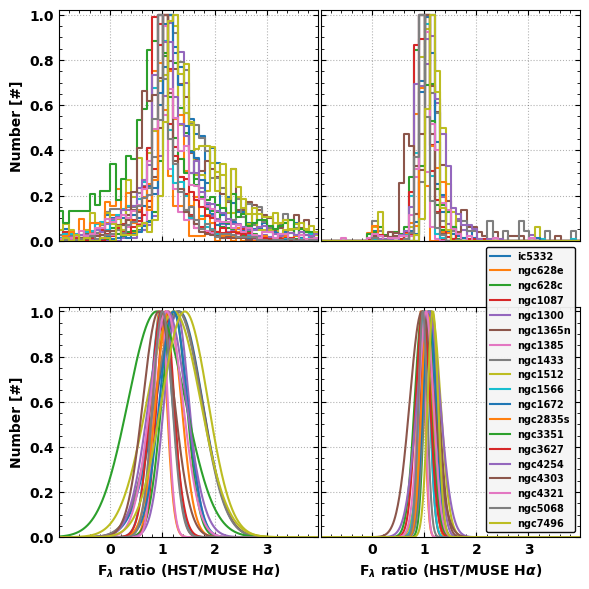

In [8]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

g_init = models.Gaussian1D(amplitude=1., mean=1, stddev=0.2)
fit_g = fitting.LevMarLSQFitter()

for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 

    ratio = muscat_table_joined_all[galaxy]['flux_hst/muse']
    mask = ratio!=0
    mask_lum = muscat_table_joined_all[galaxy]['HA6562_FLUX'][mask] > 1e5

    bins = np.arange(-10,10,0.1)
    data_hist, bins_edges = np.histogram(ratio[mask], bins=bins)
    data_hist_lmask1, bins_edges = np.histogram(ratio[mask][~mask_lum], bins=bins)
    data_hist_lmask2, bins_edges = np.histogram(ratio[mask][mask_lum], bins=bins)
    bins_center = np.linspace(bins_edges.min(), bins_edges.max(), len(bins_edges)-1)

    data_hist = data_hist/data_hist.max()
    data_hist_lmask2 = data_hist_lmask2/data_hist_lmask2.max()
    
    g = fit_g(g_init, bins_center, data_hist)
    g_lmask2 = fit_g(g_init, bins_center, data_hist_lmask2)
    print('%s: %0.2f %0.2f' %(galaxy,g.stddev.value, g_lmask2.stddev.value))

    ax1.plot(bins_center, data_hist, ds='steps-mid', label='%s' %galaxy)
    # ax1.fill_between(bins_center, data_hist, y2=0, step="mid", alpha=0.2, zorder=0)

    ax2.plot(bins_center, data_hist_lmask2, ds='steps-mid', label='%s' %galaxy)
    # ax2.fill_between(bins_center, data_hist_lmask2, y2=0, step="mid", alpha=0.2, zorder=0)

    bins = np.arange(-10,10,0.01)
    ax3.plot(bins, g(bins)/g(bins).max(), label='%s' %galaxy)
    ax4.plot(bins, g_lmask2(bins)/g_lmask2(bins).max(), label='%s' %galaxy)

for ax in [ax1, ax2, ax3, ax4]:

    ax.set_xlim(-0.99, 3.99)
    ax.grid(True, alpha=0.3, ls=':', color='black')
    ax.set_ylim([0, 1.02])
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

ax4.legend(facecolor='whitesmoke', framealpha=0.95, edgecolor='k', fontsize=7)

for ax in [ax2, ax4]:
    ax.set_yticklabels([])

for ax in [ax1, ax2]:
    ax.set_xticklabels([])

ax3.set_xlabel(r'F$_\lambda$ ratio (HST/MUSE H$\alpha$)')
ax4.set_xlabel(r'F$_\lambda$ ratio (HST/MUSE H$\alpha$)')
ax1.set_ylabel('Number [#]')
ax3.set_ylabel('Number [#]')

fig.tight_layout(h_pad=-1, w_pad=0.2)
fig.savefig('./figs/all_ratiohist.pdf', bbox_inches='tight', dpi=300)  

0.31 0.14


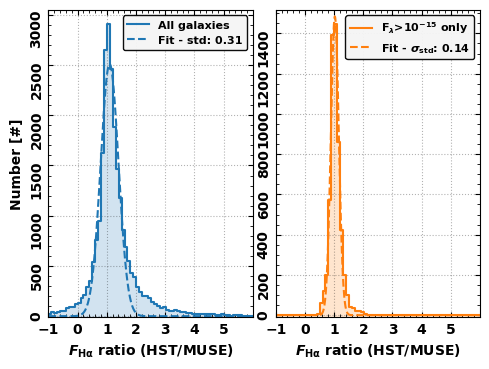

In [9]:
fig = plt.figure(figsize=(5, 3.8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

g_init = models.Gaussian1D(amplitude=1., mean=1, stddev=0.2)
fit_g = fitting.LevMarLSQFitter()

ratio = []
lum = []
star = []
nan_hst = []
nan_muse = []

for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 

    ratio += [np.squeeze(muscat_table_joined_all[galaxy]['flux_hst/muse'].quantity.value)]
    lum += [np.squeeze(muscat_table_joined_all[galaxy]['HA6562_FLUX'].quantity.value)]
    star += [np.squeeze(muscat_table_joined_all[galaxy]['flag_star'])]
    nan_hst += [muscat_table_joined_all[galaxy]['nan_hst']==0]
    nan_muse += [muscat_table_joined_all[galaxy]['nan_muse']==0]

ratio = np.hstack(ratio)
lum = np.hstack(lum)
star = np.hstack(star)
nan_hst = np.hstack(nan_hst)
nan_muse = np.hstack(nan_muse)

mask = ratio!=0
mask_stars = star != 1
mask_lum = lum > 1e5

bins = np.arange(-10,10,0.1)
data_hist, bins_edges = np.histogram(ratio[mask&mask_stars&nan_hst&nan_muse], bins=bins)
# data_hist_lmask1, bins_edges = np.histogram(ratio[mask][~mask_lum], bins=bins)
data_hist_lmask2, bins_edges = np.histogram(ratio[mask&mask_lum&mask_stars&nan_hst&nan_muse], bins=bins)

bins_center = np.linspace(bins_edges.min(), bins_edges.max(), len(bins_edges)-1)

# data_hist = data_hist/data_hist.max()
# data_hist_lmask2 = data_hist_lmask2/data_hist_lmask2.max()

g = fit_g(g_init, bins_center, data_hist)
g_lmask2 = fit_g(g_init, bins_center, data_hist_lmask2)
print('%0.2f %0.2f' %(g.stddev.value, g_lmask2.stddev.value))

ax1.plot(bins_center, data_hist, ds='steps-mid', label='All galaxies')
ax2.plot(bins_center, data_hist_lmask2, ds='steps-mid', label=r'F$_\lambda$>$10^{-15}$ only', c='C1')

ax1.fill_between(bins_center, data_hist, y2=-100, step="mid", alpha=0.2, zorder=0)
ax2.fill_between(bins_center, data_hist_lmask2, y2=-100, step="mid", alpha=0.2, zorder=0, fc='C1')

bins = np.arange(-10,10,0.01)
ax1.plot(bins, g(bins), label='Fit - std: %0.2f' %g.stddev.value, c='C0', ls='--')
ax2.plot(bins, g_lmask2(bins), label='Fit - $\sigma_\mathrm{std}$: %0.2f' %g_lmask2.stddev.value, c='C1', ls='--')

for ax in [ax1, ax2]:

    ax.set_xlim(-0.99, 6)
    ax.set_xticks(np.arange(-1,6))
    ax.grid(True, alpha=0.3, ls=':', color='black')
    
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.legend(facecolor='whitesmoke', framealpha=0.95, edgecolor='k', fontsize=8, loc='upper right')

ax1.set_ylim([-10, data_hist.max()*1.05])
ax2.set_ylim([-10, data_hist_lmask2.max()*1.05])

for label in ax1.get_yticklabels():
  label.set_rotation(90)
  label.set_ha('right')

for label in ax2.get_yticklabels():
  label.set_rotation(90)
  label.set_ha('right')
  # label.set_va('bottom')


ax1.set_xlabel(r'$F_\mathrm{H\alpha}$ ratio (HST/MUSE)')
ax2.set_xlabel(r'$F_\mathrm{H\alpha}$ ratio (HST/MUSE)')
ax1.set_ylabel('Number [#]')

fig.tight_layout(h_pad=-1, w_pad=0.3)
fig.savefig('./figs/allcomb_ratiohist.pdf', bbox_inches='tight', dpi=300)  